In [1]:
# %% 1️⃣ Imports & Paths (use DenseNet201)
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201, ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import ConfusionMatrixDisplay
# Base paths
BASE_DIR  = r"C:\Users\Sidhant\Downloads\archive"
CSV_PATH  = os.path.join(BASE_DIR, "Data_Entry_2017.csv")
IMAGE_DIRS = [os.path.join(BASE_DIR, f"images_{i:03d}") for i in range(1, 13)]

In [2]:
# %% 2️⃣ Collect & filter images
all_paths = []
for ext in ("*.png","*.jpg","*.jpeg"):
    all_paths.extend(glob.glob(os.path.join(BASE_DIR, "images_*", ext)))
    all_paths.extend(glob.glob(os.path.join(BASE_DIR, "images_*","images", ext)))
IMAGE_FILES = {os.path.basename(p).lower(): p for p in all_paths}
print("Images found:", len(IMAGE_FILES))
assert IMAGE_FILES, "No images found"

Images found: 112120


In [3]:
# %% 3️⃣ Load labels & map paths (no cap)
df = pd.read_csv(CSV_PATH, usecols=["Image Index","Finding Labels"] )
df["Image Index"] = df["Image Index"].str.strip().str.lower()
df["Finding Labels"] = df["Finding Labels"].str.split("|")
def assign_label(lbls):
    if "Mass" in lbls: return 3
    elif "Pneumonia" in lbls: return 1
    elif "Emphysema" in lbls: return 2
    else: return 0

df["Label"] = df["Finding Labels"].apply(assign_label)
df["path"] = df["Image Index"].map(IMAGE_FILES.get)
df = df[df["path"].notna()].copy()
print("Rows after mapping:", len(df))

Rows after mapping: 112120


In [4]:
# %% 4️⃣ Split 70/10/20
df_train, df_valtest = train_test_split(df, test_size=0.30,
                                        stratify=df["Label"], random_state=42)
df_val, df_test = train_test_split(df_valtest, test_size=2/3,
                                   stratify=df_valtest["Label"], random_state=42)
for subset,name in [(df_train,'Train'),(df_val,'Val'),(df_test,'Test')]:
    print(f"{name} size:", len(subset))
for subset in (df_train, df_val, df_test): subset["Label"] = subset["Label"].astype(str)

Train size: 78484
Val size: 11212
Test size: 22424


In [15]:
# %% 5️⃣ Data generators (IMG=256 + strong aug)
IMG=128; BATCH=32
train_datagen = ImageDataGenerator(
    rescale=1/255, rotation_range=15, horizontal_flip=True,
    zoom_range=0.15, width_shift_range=0.1, height_shift_range=0.1,
    brightness_range=[0.8,1.2]
)
val_datagen = ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

train_gen = train_datagen.flow_from_dataframe(
    df_train, x_col='path', y_col='Label', target_size=(IMG,IMG),
    batch_size=BATCH, class_mode='sparse'
)
val_gen = val_datagen.flow_from_dataframe(
    df_val, x_col='path', y_col='Label', target_size=(IMG,IMG),
    batch_size=BATCH, class_mode='sparse', shuffle=False
)
test_gen = test_datagen.flow_from_dataframe(
    df_test, x_col='path', y_col='Label', target_size=(IMG,IMG),
    batch_size=BATCH, class_mode='sparse', shuffle=False
)

Found 78484 validated image filenames belonging to 4 classes.
Found 11212 validated image filenames belonging to 4 classes.
Found 22424 validated image filenames belonging to 4 classes.


In [ ]:
# %% 6️⃣ Build & compile base model (DenseNet201)
base = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMG,IMG,3))
base.trainable=False    
x = GlobalAveragePooling2D()(base.output)
out = Dense(4, activation='softmax')(x)
model = Model(base.input, out)
model.compile(
    optimizer=AdamW(
        learning_rate=5e-3,   # increased for faster convergence
        weight_decay=1e-5,
        beta_1=0.9,
        beta_2=0.98,
        epsilon=1e-7
    ), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 192, 192, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 198, 198, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 96, 96, 64)           9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 96, 96, 64)           256       ['conv1/conv[0][0]']    

In [16]:
# %% 7️⃣ Train head only
cb1=[EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True),
     ModelCheckpoint('best_head.keras',monitor='val_loss',save_best_only=True)]
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=3,
    callbacks=cb1,
    workers=1,
    use_multiprocessing=False
)

Epoch 1/3
2453/2453 [==============================] - 1794s 731ms/step - loss: 0.4292 - accuracy: 0.9090 - val_loss: 0.4750 - val_accuracy: 0.9038
Epoch 2/3
2453/2453 [==============================] - 1692s 690ms/step - loss: 0.4212 - accuracy: 0.9079 - val_loss: 0.4003 - val_accuracy: 0.9100
Epoch 3/3
2453/2453 [==============================] - 1758s 717ms/step - loss: 0.4223 - accuracy: 0.9070 - val_loss: 0.4392 - val_accuracy: 0.9143


In [17]:
# %% 8️⃣ Fine‑tune stage 1: last 20 layers
for layer in base.layers[:-20]: layer.trainable=False
for layer in base.layers[-20:]: layer.trainable=True
model.compile(
    optimizer=AdamW(learning_rate=3e-5,weight_decay=1e-5),
    loss='sparse_categorical_crossentropy',metrics=['accuracy']
)
cb2=[EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True),
     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2)]
model.fit(train_gen, validation_data=val_gen, epochs=3, callbacks=cb2)
#epochs used to be 10

Epoch 1/3
2453/2453 [==============================] - 1681s 683ms/step - loss: 0.4464 - accuracy: 0.9088 - val_loss: 0.4044 - val_accuracy: 0.9057 - lr: 3.0000e-05
Epoch 2/3
2453/2453 [==============================] - 1681s 685ms/step - loss: 0.3800 - accuracy: 0.9115 - val_loss: 0.3854 - val_accuracy: 0.9080 - lr: 3.0000e-05
Epoch 3/3
2453/2453 [==============================] - 1683s 686ms/step - loss: 0.3673 - accuracy: 0.9123 - val_loss: 0.3846 - val_accuracy: 0.9105 - lr: 3.0000e-05


In [18]:
# %% 9️⃣ Fine‑tune stage 2: all layers
base.trainable=True
model.compile(
    optimizer=AdamW(learning_rate=1e-5,weight_decay=1e-5),
    loss='sparse_categorical_crossentropy',metrics=['accuracy']
)
cb3=[EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True),
     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2)]
model.fit(train_gen, validation_data=val_gen, epochs=3, callbacks=cb3)
#epochs used to be 10
# Save the fine-tuned model
PATH = r"C:\Users\Sidhant\Downloads"  
save_path = os.path.join(PATH, 'densenet201_finetuned.keras')  # specify directory and filename
model.save(save_path)
print(f"Model successfully saved to {save_path}")


Epoch 1/3
2453/2453 [==============================] - 2556s 1s/step - loss: 0.4042 - accuracy: 0.9094 - val_loss: 0.4102 - val_accuracy: 0.9062 - lr: 1.0000e-05
Epoch 2/3
2453/2453 [==============================] - 2530s 1s/step - loss: 0.3551 - accuracy: 0.9143 - val_loss: 0.3652 - val_accuracy: 0.9135 - lr: 1.0000e-05
Epoch 3/3
2453/2453 [==============================] - 2609s 1s/step - loss: 0.3336 - accuracy: 0.9160 - val_loss: 0.3543 - val_accuracy: 0.9093 - lr: 1.0000e-05
Model successfully saved to C:\Users\Sidhant\Downloads\densenet201_finetuned.keras


In [19]:
# %% 1️⃣0️⃣ Test eval + TTA ensemble
def tta_predict(m, df, steps=5):
    tta_datagen=ImageDataGenerator(rescale=1/255,rotation_range=10,horizontal_flip=True,zoom_range=0.1)
    preds=[]
    for _ in range(steps):
        gen=tta_datagen.flow_from_dataframe(df,x_col='path',y_col=None,
                                           target_size=(IMG,IMG),batch_size=BATCH,
                                           class_mode=None,shuffle=False)
        preds.append(m.predict(gen,verbose=0))
    return np.mean(preds,axis=0)
y_true=test_gen.classes
models_dict={'DenseNet201':model}
en_preds=[tta_predict(m,df_test) for m in models_dict.values()]
en_avg=np.mean(en_preds,axis=0)
en_cls=np.argmax(en_avg,axis=1)
print("Ensemble TTA accuracy:",accuracy_score(y_true,en_cls))

Found 22424 validated image filenames.
Found 22424 validated image filenames.
Found 22424 validated image filenames.
Found 22424 validated image filenames.
Found 22424 validated image filenames.
Ensemble TTA accuracy: 0.9174991080984659



DenseNet201
Found 22424 validated image filenames.
Found 22424 validated image filenames.
Found 22424 validated image filenames.
Found 22424 validated image filenames.
Found 22424 validated image filenames.
AUC Healthy=0.759
AUC Pneumonia=0.669
AUC Emphysema=0.840
AUC Lung Cancer=0.780


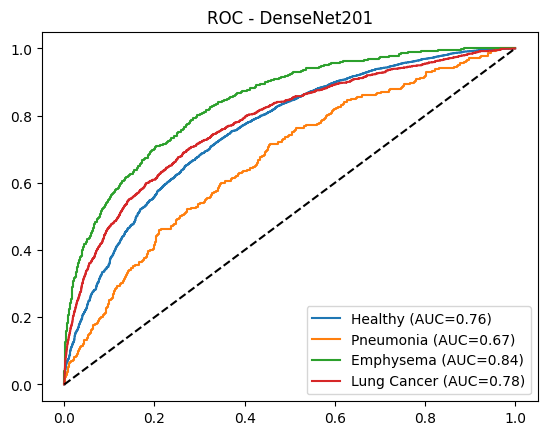

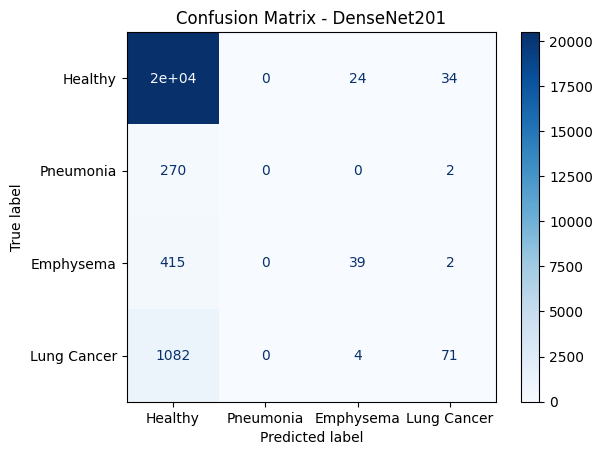

              precision    recall  f1-score   support

     Healthy     0.9206    0.9972    0.9573     20539
   Pneumonia     0.0000    0.0000    0.0000       272
   Emphysema     0.5821    0.0855    0.1491       456
 Lung Cancer     0.6514    0.0614    0.1122      1157

    accuracy                         0.9183     22424
   macro avg     0.5385    0.2860    0.3047     22424
weighted avg     0.8886    0.9183    0.8857     22424



c:\Users\Sidhant\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sidhant\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sidhant\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [20]:
# %% 1️⃣1️⃣ Comparative ROC, CM, CR
CLASS_NAMES=["Healthy","Pneumonia","Emphysema","Lung Cancer"]
y_true_bin=label_binarize(y_true,classes=list(range(4)))

for name,m in models_dict.items():
    print(f"\n{name}")
    # ROC
    y_score=tta_predict(m,df_test)
    plt.figure()
    for i in range(4):
        fpr,tpr,_=roc_curve(y_true_bin[:,i],y_score[:,i])
        print(f"AUC {CLASS_NAMES[i]}={auc(fpr,tpr):.3f}")
        plt.plot(fpr,tpr,label=f"{CLASS_NAMES[i]} (AUC={auc(fpr,tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.legend(); plt.title(f"ROC - {name}"); plt.show()
    # CM
    y_pred=np.argmax(y_score,axis=1)
    cm=confusion_matrix(y_true,y_pred)
    ConfusionMatrixDisplay(cm,display_labels=CLASS_NAMES).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}"); plt.show()
    # CR
    print(classification_report(y_true,y_pred,target_names=CLASS_NAMES,digits=4))

1/1 [==============================] - 0s 54ms/step


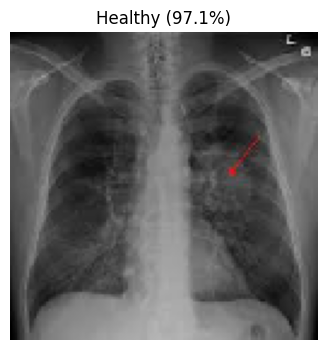

In [25]:
# %% Predict a single image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

CLASS_NAMES = ["Healthy","Pneumonia","Emphysema","Lung Cancer"]

def predict_single(img_path, model):
    # 1) Load & preprocess
    img = image.load_img(img_path, target_size=(IMG, IMG))
    arr = image.img_to_array(img) / 255.0
    batch = np.expand_dims(arr, axis=0)

    # 2) Predict
    preds = model.predict(batch)
    cls  = np.argmax(preds[0])
    conf = preds[0, cls]

    # 3) Display
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"{CLASS_NAMES[cls]} ({conf*100:.1f}%)")
    plt.show()

# Example:
predict_single(r"C:\\Users\\Sidhant\\Downloads\\lcxray.jpg", model)


In [31]:
# %% Grad‑CAM heatmap overlay
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_name=None):
    """Returns a (H,W) heatmap for the top‑predicted class."""
    if last_conv_name is None:
        # automatically find the last conv2d layer
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_name = layer.name
                break

    # Build a model that maps input → [conv_output, predictions]
    conv_layer = model.get_layer(last_conv_name)
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [conv_layer.output, model.output]
    )

    # Compute gradient of top class wrt feature map
    with tf.GradientTape() as tape:
        conv_outs, preds = grad_model(img_array)
        top_class = tf.argmax(preds[0])
        loss = preds[:, top_class]
    grads = tape.gradient(loss, conv_outs)[0]       # (Hf, Wf, C)
    conv_outs = conv_outs[0]                        # (Hf, Wf, C)

    # Global average pooling of gradients
    weights = tf.reduce_mean(grads, axis=(0,1))     # (C,)
    cam = tf.reduce_sum(conv_outs * weights, axis=-1)  # (Hf, Wf)

    # Normalize to [0,1]
    cam = tf.maximum(cam, 0) / (tf.reduce_max(cam) + 1e-8)
    return cam.numpy()

def overlay_heatmap(img_path, model, alpha=0.4):
    # 1) Load & preprocess
    img = image.load_img(img_path, target_size=(IMG, IMG))
    arr = image.img_to_array(img) / 255.0
    batch = np.expand_dims(arr, axis=0)

    # 2) Make heatmap
    heatmap = make_gradcam_heatmap(batch, model)

    # 3) Resize heatmap to image size
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.stack([heatmap]*3, axis=-1)
    heatmap = tf.image.resize(heatmap, (IMG, IMG)).numpy().astype(np.uint8)

    # 4) Overlay
    img_rgb = (arr * 255).astype(np.uint8)
    overlay = heatmap * alpha + img_rgb

    # 5) Display
    plt.figure(figsize=(6,6))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap="gray")
    plt.title("Original")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(overlay.astype(np.uint8))
    plt.title("Grad‑CAM Overlay")
    plt.axis("off")
    plt.show()

# Example:
overlay_heatmap(r"C:\\Users\\Sidhant\\Downloads\\lcxray.jpg", model)


ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 192, 192, 3), found shape=(1, 128, 128, 3)

In [32]:
# -*- hard_negative_mining.py -*-

import numpy as np
import pandas as pd

# 1️⃣ Run inference on the TRAINING set (no shuffling!)
train_infer_gen = ImageDataGenerator(rescale=1/255).flow_from_dataframe(
    train_df, 
    x_col='path', 
    y_col='Label',
    target_size=(IMG, IMG),
    batch_size=BATCH,
    class_mode='sparse',
    shuffle=False
)

# 2️⃣ Predict and collect misclassified disease samples
y_true = train_infer_gen.classes
y_pred = model.predict(train_infer_gen, verbose=0)
y_pred_cls = np.argmax(y_pred, axis=1)

# mask for disease misclassifications
mask = (y_true != 0) & (y_pred_cls != y_true)
hard_indices = np.where(mask)[0]

# get the filepaths and labels of those
hard_paths  = [ train_infer_gen.filepaths[i] for i in hard_indices ]
hard_labels = [ int(y_true[i])              for i in hard_indices ]

print(f"Found {len(hard_paths)} hard negatives to oversample")

# 3️⃣ Build a small DataFrame of hard negatives
hard_df = pd.DataFrame({
    'path':  hard_paths,
    'Label': hard_labels
})

# 4️⃣ Oversample them k‑times (e.g. k=3)
k = 3
augmented_train_df = pd.concat([train_df, pd.concat([hard_df]*k, ignore_index=True)], ignore_index=True)

# 5️⃣ Shuffle the new training DataFrame
augmented_train_df = augmented_train_df.sample(frac=1, random_state=42).reset_index(drop=True)
print("New training set size:", len(augmented_train_df))

# 6️⃣ Re‑build the train_gen on the augmented DataFrame
aug_train_gen = train_datagen.flow_from_dataframe(
    augmented_train_df,
    x_col='path',
    y_col='Label',
    target_size=(IMG, IMG),
    batch_size=BATCH,
    class_mode='sparse',
    shuffle=True
)

# 7️⃣ Continue training for a couple more epochs
cb_hard = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)
]
model.fit(
    aug_train_gen,
    validation_data=val_gen,
    epochs=2,               # a few more passes
    callbacks=cb_hard,
    workers=1,
    use_multiprocessing=False
)


NameError: name 'train_df' is not defined